# Are we really dealing with disaster?
## NLP tweet classification project
The data is taken from the Natural Language Processing with Disaster Tweets competition on Kaggle<br>
https://www.kaggle.com/competitions/nlp-getting-started/overview

### Problem description & project motivation:

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

**But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:**

<img src="data\tweet_screenshot.png">

**The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.**

## Imports

In [106]:
import pandas as pd

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

import spacy

# vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# utilities
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate

## Install Spacy for text processing

In [107]:
!spacy download en_core_web_sm

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Load data

In [108]:
train_df = pd.read_csv("../sda_final_project_disaster_tweets/train.csv")

## Description of the data

Each sample in the train and test set has the following information:

* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* The location the tweet was sent from (may also be blank)

## Exploratory Data Analysis

### Inspecting the data

Since test.csv does not include labels, we will perform our analysis only on the data in train.csv

In [109]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [110]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Unique values

In [111]:
print(f"Unique tweets: {len(train_df.text.unique())}")
print(f"Unique locations: {len(train_df.location.unique())}")
print(f"Unique keywords: {len(train_df.location.unique())}")


Unique tweets: 7503
Unique locations: 3342
Unique keywords: 3342


### Missing values

In [112]:
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

## Visualization

### Target variable distribution

[[Text(0, 0, 'not disaster'), Text(1, 0, 'disaster')],
 Text(0.5, 0, 'target label')]

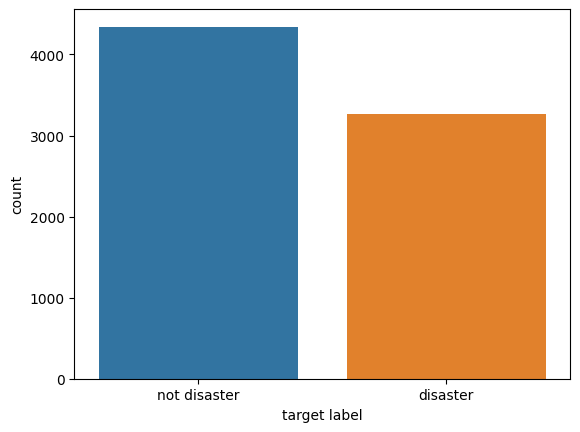

In [113]:
ax = sns.countplot(data=train_df, x='target')
ax.set(xticklabels = (['not disaster', 'disaster']), xlabel="target label")

### Tweet length distribution

In [114]:
# get the length of each tweet
train_df["text_length"] = [len(txt.split()) for txt in train_df.text]
train_df.describe()

,id,target,text_length
count,7613.000000,7613.00000,7613.000000
mean,5441.934848,0.42966,14.903586
std,3137.116090,0.49506,5.732604
min,1.000000,0.00000,1.000000
25%,2734.000000,0.00000,11.000000
50%,5408.000000,0.00000,15.000000
75%,8146.000000,1.00000,19.000000
max,10873.000000,1.00000,31.000000


[Text(0.5, 0, 'tweet length')]

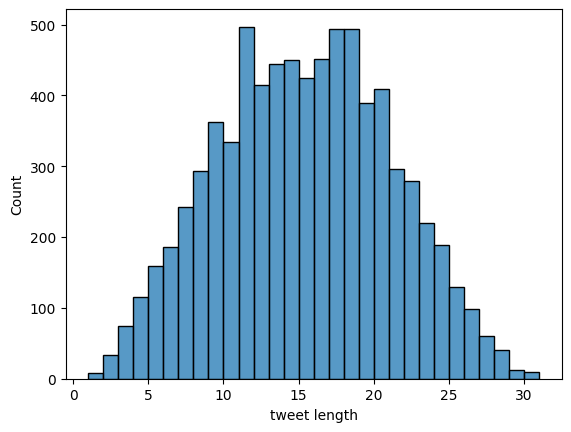

In [115]:
ax = sns.histplot(data=train_df, x="text_length", bins=30)
ax.set(xlabel="tweet length")

### Dealing with missing values

In [116]:
selected_rows_location = train_df[~train_df['location'].isnull()]
selected_rows_location

,id,keyword,location,text,target,text_length
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,5
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,10
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,9
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,7
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,13
...,...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0,7
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0,21
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,20
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,12


In [117]:
selected_rows_keyword = train_df[~train_df['keyword'].isnull()]
selected_rows_keyword

,id,keyword,location,text,target,text_length
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,5
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,10
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,9
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,7
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,13
...,...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0,7
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,20
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,12
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,13


In [118]:
# replace the missing values with an empty string ''
train_df['location'] = train_df['location'].fillna('')
train_df['keyword'] = train_df['keyword'].fillna('')

In [119]:
train_df

,id,keyword,location,text,target,text_length
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,,,Forest fire near La Ronge Sask. Canada,1,7
2,5,,,All residents asked to 'shelter in place' are ...,1,22
3,6,,,"13,000 people receive #wildfires evacuation or...",1,8
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,16
...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1,11
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1,20
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8
7611,10872,,,Police investigating after an e-bike collided ...,1,19


## Data preparation

### Cleaning the data

In [120]:
nlp = spacy.load('en_core_web_sm')

In [121]:
# custom functions for data cleaning

def preprocess_text(txt: str) -> str:
    """
    Tokenizing, lemmatizing, lowercasing, removing stopwords, 
    removing non-alphanumeric chars, and removing words with len >= 2 from a single sequence.
    Returns a string of the processed and concatenated tokens.
    """
    txt = nlp(txt)
    return " ".join([token.lemma_.lower() for token in txt if not token.is_stop and token.is_alpha and len(token) > 2])

def preprocess_location(txt: str) -> str:
    """
    Tokenizing, lemmatizing, lowercasing, removing stopwords, 
    removing non-alphanumeric chars.
    Returns a string of the processed and concatenated tokens.
    """
    txt = nlp(txt)
    return " ".join([token.lemma_.lower() for token in txt if not token.is_stop and token.is_alpha])

def preprocess_keyword(txt: str) -> str:
    """
    Replacing the %20 sequence with a blankspace.
    Tokenizing, lemmatizing, lowercasing, removing stopwords, 
    removing non-alphanumeric chars.
    Returns a string of the processed and concatenated tokens.
    """
    txt = nlp(txt.replace("%20", " "))
    return " ".join([token.lemma_.lower() for token in txt if not token.is_stop and token.is_alpha])

In [122]:
clean_text = [preprocess_text(txt) for txt in train_df.text]

In [123]:
clean_location = [preprocess_location(txt) for txt in train_df.location]

In [124]:
clean_keyword = [preprocess_keyword(txt) for txt in train_df.keyword]

In [125]:
train_df["clean_text"] = clean_text
train_df["clean_location"] = clean_location
train_df["clean_keyword"] = clean_keyword

### Vectorizing the data

#### Combining tf-idf vectorization and count vectorization approaches

In [126]:
MAX_LEN = 10000

In [127]:
# for text
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

vectorizer_tfidf = TfidfVectorizer(max_features=MAX_LEN)
vectorized_text_tfidf = vectorizer_tfidf.fit_transform(train_df["clean_text"])

# for location, keyword
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

vectorizer_count = CountVectorizer(max_features=MAX_LEN)
vectorized_keywords = vectorizer_count.fit_transform(train_df["clean_location"])
vectorized_location = vectorizer_count.fit_transform(train_df["clean_keyword"])


In [128]:
# shapes of the arrays of vectorized sequences
print(f"Shape of the array of tf-idf vectors (text): {vectorized_text_tfidf.shape}")
print(f"Shape of the array of count vectors (keywords): {vectorized_keywords.shape}")
print(f"Shape of the array of count vectors (location): {vectorized_location.shape}")

Shape of the array of tf-idf vectors (text): (7613, 10000)
Shape of the array of count vectors (keywords): (7613, 2731)
Shape of the array of count vectors (location): (7613, 186)


In [129]:
# padding the sequences to 10000 and adding them together

# we need to append a vector np.zeros of len = 10000-array.shape[1] where array is keywords, location
padding_length_keywords = vectorized_text_tfidf.shape[1] - vectorized_keywords.shape[1]
padding_length_location = vectorized_text_tfidf.shape[1] - vectorized_location.shape[1]

def pad_vectors(array_of_vectors: np.ndarray, padding_length: int) -> np.ndarray:
    padded_vectors = [np.append(vector, np.zeros([padding_length])) for vector in array_of_vectors]
    return np.array(padded_vectors)

In [130]:
vectorized_keywords_padded = pad_vectors(vectorized_keywords.toarray(), padding_length_keywords)
vectorized_location_padded = pad_vectors(vectorized_location.toarray(), padding_length_location)

In [131]:
print(vectorized_keywords_padded.shape)
print(vectorized_location_padded.shape)

(7613, 10000)
(7613, 10000)


#### Tf-idf encoding the whole dataset

In [132]:
train_df['clean_joined_text'] = train_df['clean_text'] + train_df['clean_location'] + train_df['clean_keyword']

In [133]:
vectorizer_tfidf_joined_text = TfidfVectorizer(max_features=MAX_LEN)
vectorized_text_tfidf = vectorizer_tfidf_joined_text.fit_transform(train_df["clean_joined_text"])

## Training models

### Models trained with combined input obtained by combining vectorization techniques (tf-idf and count vectorization)

In [134]:
# combining different vectorization embeddings into one
X = vectorized_text_tfidf + vectorized_keywords_padded + vectorized_location_padded

In [135]:
X_train_combined_input, X_test_combined_input, y_train_combined_input, y_test_combined_input = train_test_split(X,
                                                                                                                train_df['target'], 
                                                                                                                test_size=0.2, 
                                                                                                                random_state=42,
                                                                                                                stratify=train_df['target'])

#### Logistic regression

In [136]:
clf_logistic_regression_combined_input = LogisticRegression(random_state=0)

In [137]:
scores_logistic_regression_combined_input = cross_val_score(clf_logistic_regression_combined_input,
                                                            np.asarray(X_train_combined_input),
                                                            y_train_combined_input,
                                                            cv=10)

In [138]:
print(scores_logistic_regression_combined_input)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_logistic_regression_combined_input.mean(), scores_logistic_regression_combined_input.std()))

[0.75205255 0.81116585 0.76026273 0.74220033 0.7816092  0.74384236
 0.7635468  0.77504105 0.74712644 0.77504105]
0.77 accuracy with a standard deviation of 0.02


In [139]:
clf_logistic_regression_combined_input.fit(np.asarray(X_train_combined_input), y_train_combined_input)

LogisticRegression(random_state=0)

In [140]:
print(classification_report(y_test_combined_input, 
                            clf_logistic_regression_combined_input.predict(np.asarray(X_test_combined_input))))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       869
           1       0.79      0.69      0.74       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



#### Multinomial Naive Bayes

In [141]:
clf_multinomial_naive_bayes_combined_input = MultinomialNB()

In [142]:
scores_multinomial_naive_bayes_combined_input = cross_val_score(clf_multinomial_naive_bayes_combined_input,
                                                                np.asarray(X_train_combined_input),
                                                                y_train_combined_input,
                                                                cv=10)

In [143]:
print(scores_multinomial_naive_bayes_combined_input)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_multinomial_naive_bayes_combined_input.mean(), scores_multinomial_naive_bayes_combined_input.std()))

[0.74055829 0.79638752 0.75369458 0.75041051 0.75697865 0.73891626
 0.74220033 0.77668309 0.73891626 0.75041051]
0.75 accuracy with a standard deviation of 0.02


In [144]:
clf_multinomial_naive_bayes_combined_input.fit(np.asarray(X_train_combined_input),
                                                          y_train_combined_input)

MultinomialNB()

In [145]:
print(classification_report(y_test_combined_input,
                            clf_multinomial_naive_bayes_combined_input.predict(np.asarray(X_test_combined_input))))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       869
           1       0.76      0.72      0.74       654

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523



#### Cross-validation

### Models trained with input obtained by vectorizing the the entire dataset (joined columns) using tf-idf vectorization

In [146]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(vectorized_text_tfidf.toarray(),
                                                                            train_df['target'],
                                                                            test_size=0.2, 
                                                                            random_state=42,
                                                                            stratify=train_df['target'])

#### Logistic Regression

In [147]:
clf_logistic_regression_tfidf = LogisticRegression(random_state=0)

##### Cross-validation

In [148]:
scores_logistic_regression_tfidf = cross_val_score(clf_logistic_regression_tfidf,
                                                   X_train_tfidf,
                                                   y_train_tfidf,
                                                   cv=10)

In [149]:
print(scores_logistic_regression_tfidf)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_logistic_regression_tfidf.mean(), scores_logistic_regression_tfidf.std()))

[0.76026273 0.79802956 0.78325123 0.79967159 0.79967159 0.77832512
 0.80623974 0.78489327 0.79967159 0.80295567]
0.79 accuracy with a standard deviation of 0.01


In [150]:
clf_logistic_regression_tfidf.fit(np.asarray(X_train_tfidf), y_train_tfidf)

LogisticRegression(random_state=0)

In [151]:
print(classification_report(y_test_tfidf, clf_logistic_regression_tfidf.predict(np.asarray(X_test_tfidf))))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       869
           1       0.85      0.64      0.73       654

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523



#### Multinomial Naive Bayes

In [152]:
clf_multinomial_naive_bayes_tfidf = MultinomialNB()

##### Cross-validation

In [153]:
scores_multinomial_naive_bayes_tfidf = cross_val_score(clf_multinomial_naive_bayes_tfidf,
                                                       X_train_tfidf,
                                                       y_train_tfidf,
                                                       cv=10)

In [154]:
print(scores_multinomial_naive_bayes_tfidf)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_multinomial_naive_bayes_tfidf.mean(), scores_multinomial_naive_bayes_tfidf.std()))

[0.77668309 0.80131363 0.77339901 0.79638752 0.8045977  0.78817734
 0.77504105 0.80295567 0.78325123 0.8045977 ]
0.79 accuracy with a standard deviation of 0.01


In [155]:
clf_multinomial_naive_bayes_tfidf.fit(np.asarray(X_train_tfidf), y_train_tfidf)

MultinomialNB()

In [156]:
print(classification_report(y_test_tfidf, clf_multinomial_naive_bayes_tfidf.predict(np.asarray(X_test_tfidf))))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       869
           1       0.82      0.67      0.74       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523



### Model evaluation

## Conclusion

So far we can see that:
* In terms of accuracy - Logistic Regression trained with combined tf-idf and count vectorized features is the best at 79%
    * Logistic Regression with combined encoding and Multinomial Naive Bayes are 1% and 2% worse respectively
    * But they make up for it in terms of other metrics

### Model prediction comparison

#### Combined input (tf-idf + count vecotorization)

In [157]:
print(classification_report(y_test_combined_input, 
                            clf_logistic_regression_combined_input.predict(np.asarray(X_test_combined_input))))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       869
           1       0.79      0.69      0.74       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



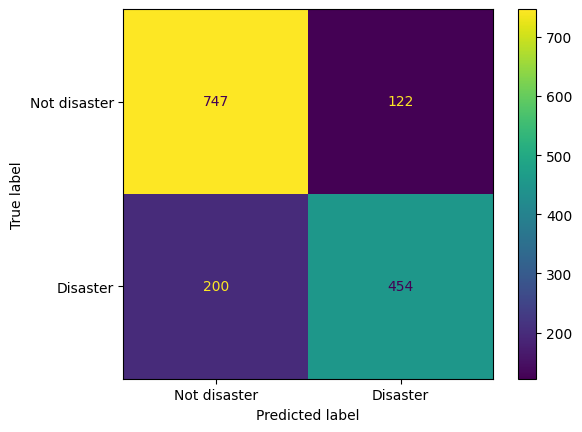

In [158]:
# plotting a confusion matrix - logistic regression with combined input (tf-idf + count vecotorization)

predictions_logistic_regression_combined_input = clf_logistic_regression_combined_input.predict(np.asarray(X_test_combined_input))

cm = confusion_matrix(y_test_combined_input,
                      predictions_logistic_regression_combined_input)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Not disaster", "Disaster"])

disp.plot()

In [159]:
print(classification_report(y_test_combined_input,
                            clf_multinomial_naive_bayes_combined_input.predict(np.asarray(X_test_combined_input))))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       869
           1       0.76      0.72      0.74       654

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523



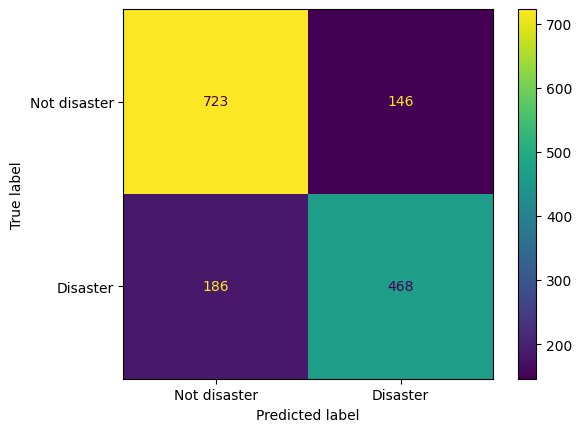

In [160]:
# plotting a confusion matrix - multinomial naive bayes with combined input (tf-idf + count vecotorization)

predictions_multinomial_naive_bayes_combined_input = clf_multinomial_naive_bayes_combined_input.predict(np.asarray(X_test_combined_input))

cm = confusion_matrix(y_test_combined_input,
                      predictions_multinomial_naive_bayes_combined_input)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Not disaster", "Disaster"])

disp.plot()

#### Tf-idf input

In [161]:
print(classification_report(y_test_tfidf,
                            clf_logistic_regression_tfidf.predict(np.asarray(X_test_tfidf))))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       869
           1       0.85      0.64      0.73       654

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523



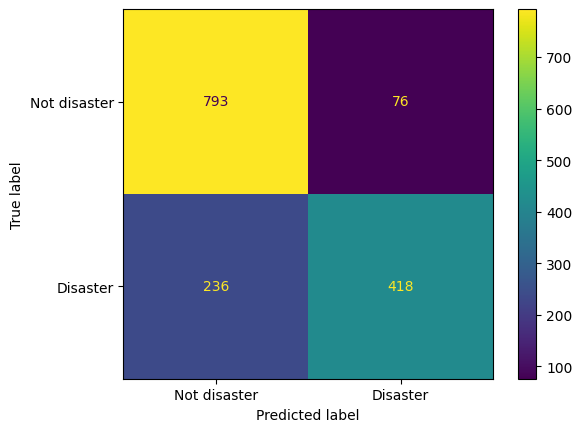

In [162]:
# plotting a confusion matrix - logistic regression with tf-idf input

predictions_logistic_regression_tfidf = clf_logistic_regression_tfidf.predict(np.asarray(X_test_tfidf))

cm = confusion_matrix(y_test_tfidf,
                      predictions_logistic_regression_tfidf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Not disaster", "Disaster"])

disp.plot()

In [163]:
print(classification_report(y_test_tfidf,
                            clf_multinomial_naive_bayes_tfidf.predict(np.asarray(X_test_tfidf))))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       869
           1       0.82      0.67      0.74       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523



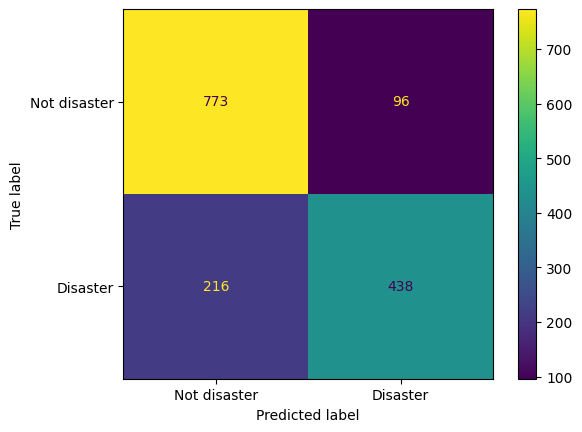

In [164]:
# plotting a confusion matrix - multinomial naive bayes with tf-idf input

predictions_multinomial_naive_bayes_tfidf = clf_multinomial_naive_bayes_tfidf.predict(np.asarray(X_test_tfidf))

cm = confusion_matrix(y_test_tfidf,
                      predictions_multinomial_naive_bayes_tfidf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Not disaster", "Disaster"])

disp.plot()

## TO DO
* add code that samples randomly from the location and keyword columns
* add docstrings to a function
* clean the project structure
* label the graphs
* https://datascience.stackexchange.com/questions/56804/sckit-learn-cross-validation-and-model-retrain
---
* ~ stratify parameter
* add more metrics to cross validation
    * stratified kfold? 
* ~ confusion matrices
* https://black.readthedocs.io/en/stable/getting_started.html
* kaggle score improve
* https://eli5.readthedocs.io/en/latest/overview.html
* add a cell where you will give an input tweet sequence and you will get an output prediction
* update the conclusion
